# Write workflow for easy use of test sets
* Train on G2 as starting point
* Define test set
* Check correct projection and normalization

In [13]:
# Use:  ssh augustin@144.213.124.120 -N -L  5555:127.0.0.1:8888
# To open the ssh tunnel and use this notebook
import ConquesTools
help(ConquesTools)

from ConquesTools.analysis.descriptors import acsf, soap, mbsf

Help on package ConquesTools:

NAME
    ConquesTools

PACKAGE CONTENTS
    analysis (package)
    data (package)
    input (package)
    io (package)
    potentials (package)
    version

VERSION
    0.1.9

AUTHOR
    Anh Khoa Augustin Lu

FILE
    /Users/admin/workspace/MLFF_tools/ConquesTools/__init__.py




ModuleNotFoundError: No module named 'dscribe'

In [31]:
from ConquesTools.analysis import laaf, ts_lpp, lpp, pca
from tqdm.auto import tqdm

ImportError: cannot import name 'SOAP' from partially initialized module 'ConquesTools.analysis.descriptors.soap' (most likely due to a circular import) (/Users/admin/workspace/MLFF_tools/ConquesTools/analysis/descriptors/soap.py)

In [2]:
import os
import pprint
import ase
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

work_directory = './workflow_test_set/'
if not os.path.isdir(work_directory):
    os.makedirs(work_directory)

In [3]:
from ConquesTools.analysis.pca import perform_pca
from ConquesTools.analysis.plots.classification import plot_clustering_results, plot_true_labels, plot_predictions
import pandas as pd

from sklearn.manifold import TSNE

# Training set

* All NVT 

## Trajectories

In [21]:
# Crystals
crystal_temperature_dict = {0:300,1:600,2:900,3:1200, 4:1500}
crystal_temperature_list = len(crystal_temperature_dict)
crystal_phase_list = [
    'mono_vac'
]
phase_dict = {}

for ti, temp in crystal_temperature_dict.items():
    phase_dict[f'{temp}'] = f'./mono/junk/data/{temp}/trajectory.xyz'

temperature_per_phase = {
    'mono_vac':len(crystal_temperature_dict)}    

phase_list = crystal_phase_list 
#phase_list = crystal_phase_list

number_of_classes = len(phase_list)

In [17]:
print(phase_dict)

{'300': './mono/junk/data/300/trajectory.xyz', '600': './mono/junk/data/600/trajectory.xyz', '900': './mono/junk/data/900/trajectory.xyz', '1200': './mono/junk/data/1200/trajectory.xyz', '1500': './mono/junk/data/1500/trajectory.xyz'}


## G2 descriptor

In [22]:
r_d = 7.0
r_a = 5.0
number_of_data_per_phase = 480
number_of_eta = 50

element_conversion = {'Si': 0, 'O': 1}
species = ['Si']
target_element = 0  # TARGET IS Silicon. Here it is counted as ['Si', 'O']. Need to check that!!!

this_descriptor = 'ACSF_G2'

print(
    f'Calculating with descriptor: {this_descriptor} and {number_of_eta} eta')

laaf_file = f'{work_directory}/laaf_{this_descriptor}_{number_of_eta}_eta_{r_d}_{r_a}_{target_element}.csv'

for phase_index, phase in tqdm(enumerate(phase_dict),
                               total=len(phase_dict),
                               desc=this_descriptor):

    xyz_file = phase_dict[phase]

    # Use 20 snapshots per trajectory
    if 'glass' in phase:
        selected_snapshots = '-1000::50'
    elif 'liquid' in phase:
        selected_snapshots = '-1000::50'
    else:
        selected_snapshots = '-1000::50'

    number_of_data = int(number_of_data_per_phase / temperature_per_phase['mono_vac'])

    print(
        xyz_file,
        ' : ',
        number_of_data,
    )
    my_laaf = laaf.AverageFingerprintCalculator(
        cutoff_descriptor=r_d,
        cutoff_average=r_a,
        input_file=xyz_file,
        selected_snapshots=selected_snapshots,
        number_of_eta=number_of_eta,
        element_conversion=element_conversion,
        descriptor_type=this_descriptor,
    )

    my_laaf.compute_averaged_fingerprints_random(
        append=phase_index > 0,
        output_file=laaf_file,
        target_element=target_element,
        number_of_data=number_of_data,  # generated number of data,
    )

Calculating with descriptor: ACSF_G2 and 50 eta


ACSF_G2:   0%|          | 0/5 [00:00<?, ?it/s]

./mono/junk/data/300/trajectory.xyz  :  96


NameError: name 'laaf' is not defined

## Train model

In [6]:
from ConquesTools.analysis.ts_lpp import TsLpp

Shape of data set:  (4800, 100)
*************
Training data
Number of data = 4800
Number of features = 100
Number of clusters = 10
Reduced dimension = 2
*************
Searching optimized hyperparameters...
Dimension list is: [5, 10]
Sigma list is: [10, 100]


TS-LPP (dm,sigma) grid optimization:   0%|          | 0/2 [00:00<?, ?it/s]

Intermediate dimension = 5, sigma = 10, pseudo F = 53207.79673888364
2


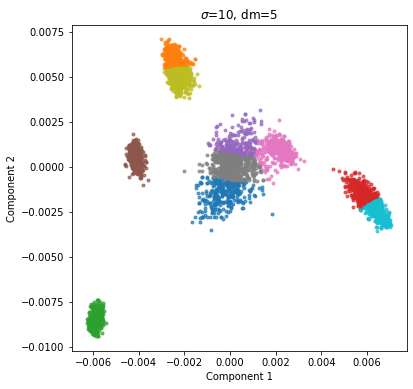

Intermediate dimension = 5, sigma = 100, pseudo F = 57235.42123746067
2


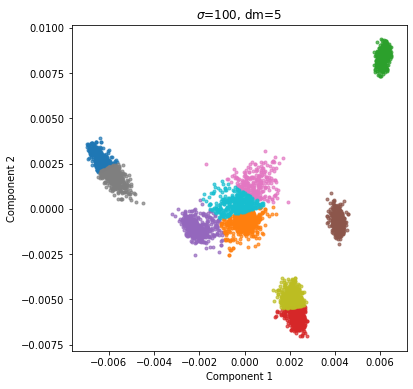

Intermediate dimension = 10, sigma = 10, pseudo F = 58893.214205797936
2


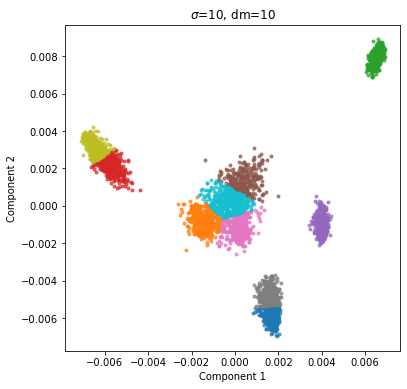

Intermediate dimension = 10, sigma = 100, pseudo F = 58235.87058314688
2


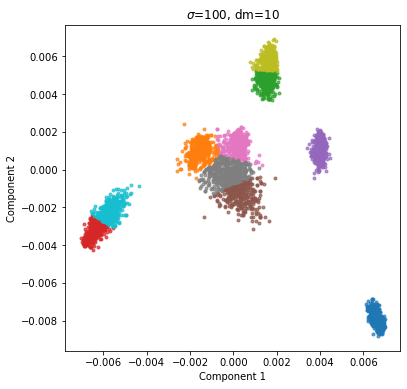

Best results found for: dm = 10, sigma = 10 with pseudo F score of 58893.214205797936

*************
Hyperparameter optimization...
Optimized sigma = 10
Optimized dm = 10
*************
*************
clustering results
Pseudo F = 58893.214205797936
*************
2 DIMENSIONS


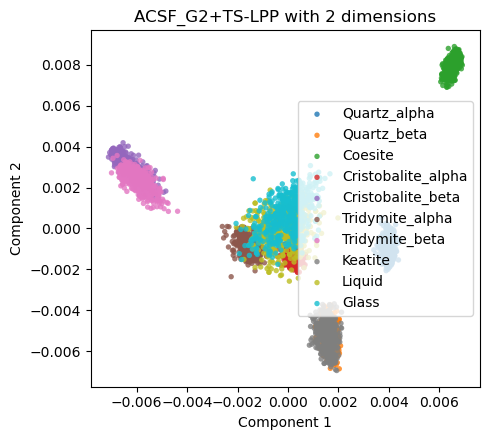

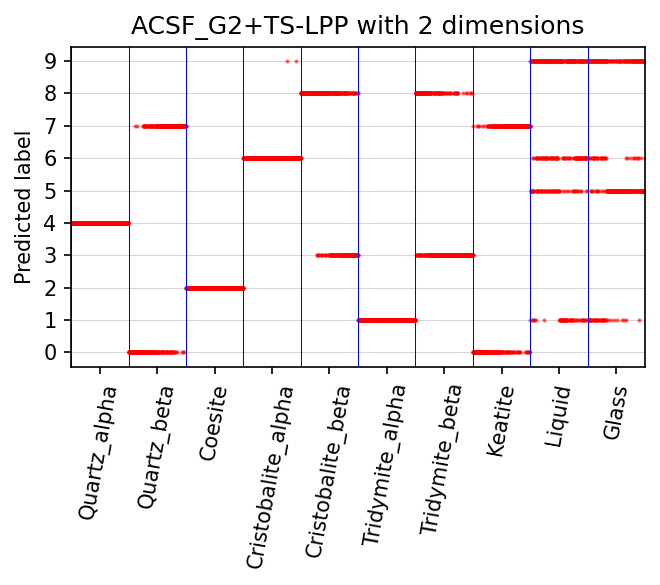

In [7]:
number_of_clusters = len(phase_list)
knn =11
number_of_dimensions = 2

label_file = f'{work_directory}/ts_lpp_{this_descriptor}_{number_of_eta}_eta_labels.dat'

x_data = pd.read_csv(laaf_file, header=None).values

my_tslpp = TsLpp(clustering_type='k_means')

projected_data, labels, Y_middle, Y_final = my_tslpp.fit(
    x_data,
    number_of_clusters=number_of_clusters,
    number_of_dimensions=number_of_dimensions,
    k_nearest_neighbors=knn,
    silent=False,
    dimension_list = [5,10],
    sigma_list = [10,100],
)

case_label = f'{this_descriptor}+TS-LPP with {number_of_dimensions} dimensions'

plot_true_labels(
    classification_data=projected_data,
    class_list=phase_list,
    case_label=case_label,
    data_per_class=number_of_data_per_phase,
)
plot_predictions(
    case_label=case_label,
    label_list=labels,
    class_list = phase_list,
    data_per_class=number_of_data_per_phase,
)

# Check needed parts for transformation/projection

In [8]:
x_data
Y_middle
Y_final


array([[-0.95084149, -0.04500094,  0.17479497,  0.14660316,  0.00992948,
         0.03475128,  0.04035897,  0.04022652,  0.00380405,  0.00514804],
       [-0.14707328, -0.32403831, -0.91143587,  0.05750822, -0.00170454,
         0.0279998 , -0.00588053, -0.01012912,  0.03793203, -0.03489335]])

# Test set

## Select trajectory

In [9]:
#test_trajectory_file = '../../CONQUEST/molecular_dynamics/long_runs/T_1200/quartz_beta/trajectory.xyz'
test_trajectory_file = '../../CONQUEST/molecular_dynamics/npt/crystal_phases/T_1200/cristobalite_alpha/trajectory.xyz'
#test_trajectory_file = '../../LAMMPS/Tersoff/equilibrium_runs/T_1200/coesite/trajectory.xyz'
#test_trajectory_file = '../../LAMMPS/Tersoff/melt_quench/npt/324_atoms/1e10/glass_tersoff_1e11.xyz'

## Test descriptors

Calculating for test set with descriptor: ACSF_G2 and 50 eta
Using local descriptor. Any other descriptor in input will be discarded.
Setting Parameters (two-body, three-body) for descriptor


  0%|          | 0/20 [00:00<?, ?it/s]

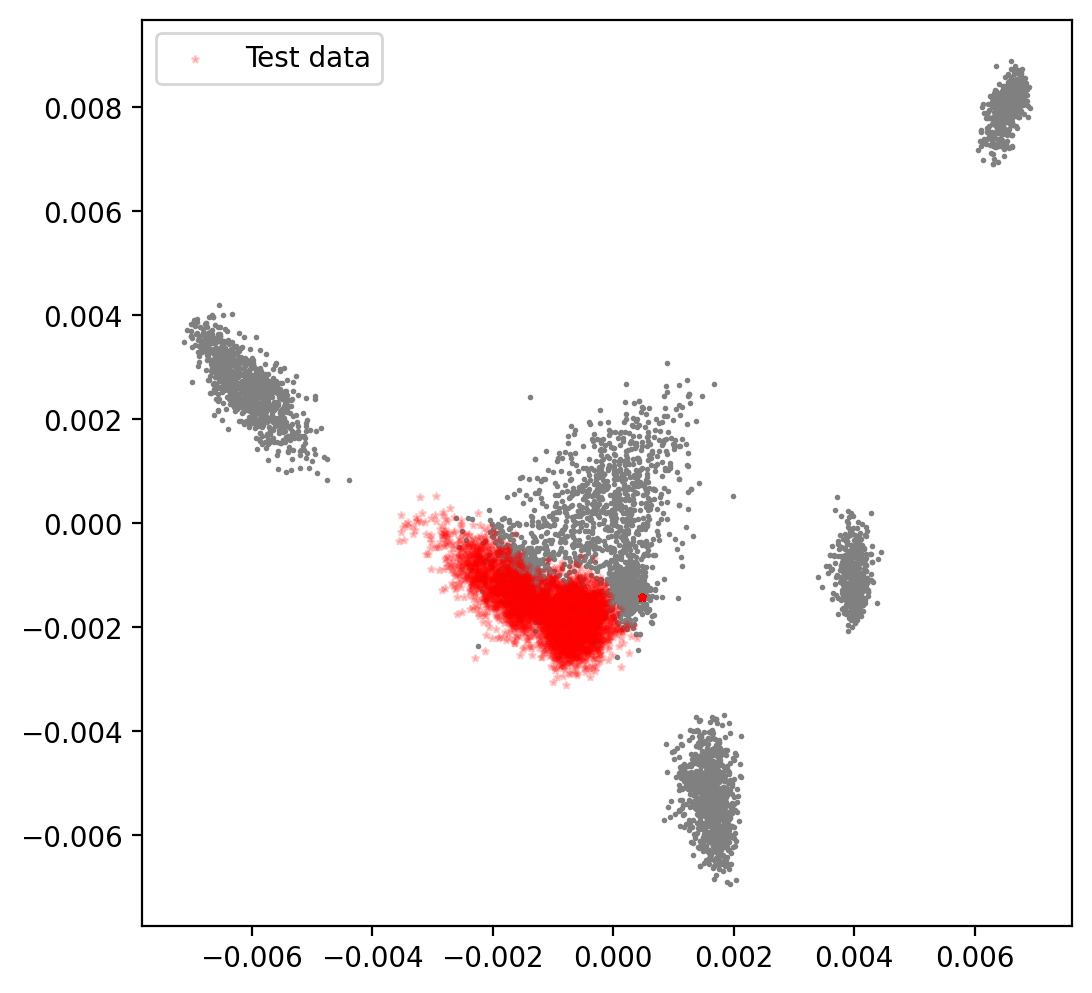

In [10]:
print(f'Calculating for test set with descriptor: {this_descriptor} and {number_of_eta} eta')

test_laaf_file = f'{work_directory}/test_data.csv'

selected_snapshots = '::500'

my_laaf = laaf.AverageFingerprintCalculator(
    cutoff_descriptor=r_d, cutoff_average=r_a,
    input_file=test_trajectory_file,
    selected_snapshots=selected_snapshots,
    number_of_eta=number_of_eta,
    element_conversion=element_conversion,
    descriptor_type=this_descriptor,
)

my_laaf.compute_averaged_fingeprints_selection(
    append = False,
    output_file=test_laaf_file,
    target_element=target_element,
    #number_of_data=number_of_data,  # generated number of data,
)
test_data = pd.read_csv(test_laaf_file, header=None).values
test_transformed = my_tslpp.transform(test_data)
f,ax = plt.subplots(figsize=(6,6),dpi=200)
ax.scatter(*projected_data.T, color = '0.5', s = 1)
ax.scatter(*test_transformed.T, color = 'red', s = 5, marker='*', label='Test data',alpha=0.2)
ax.legend()
plt.show()

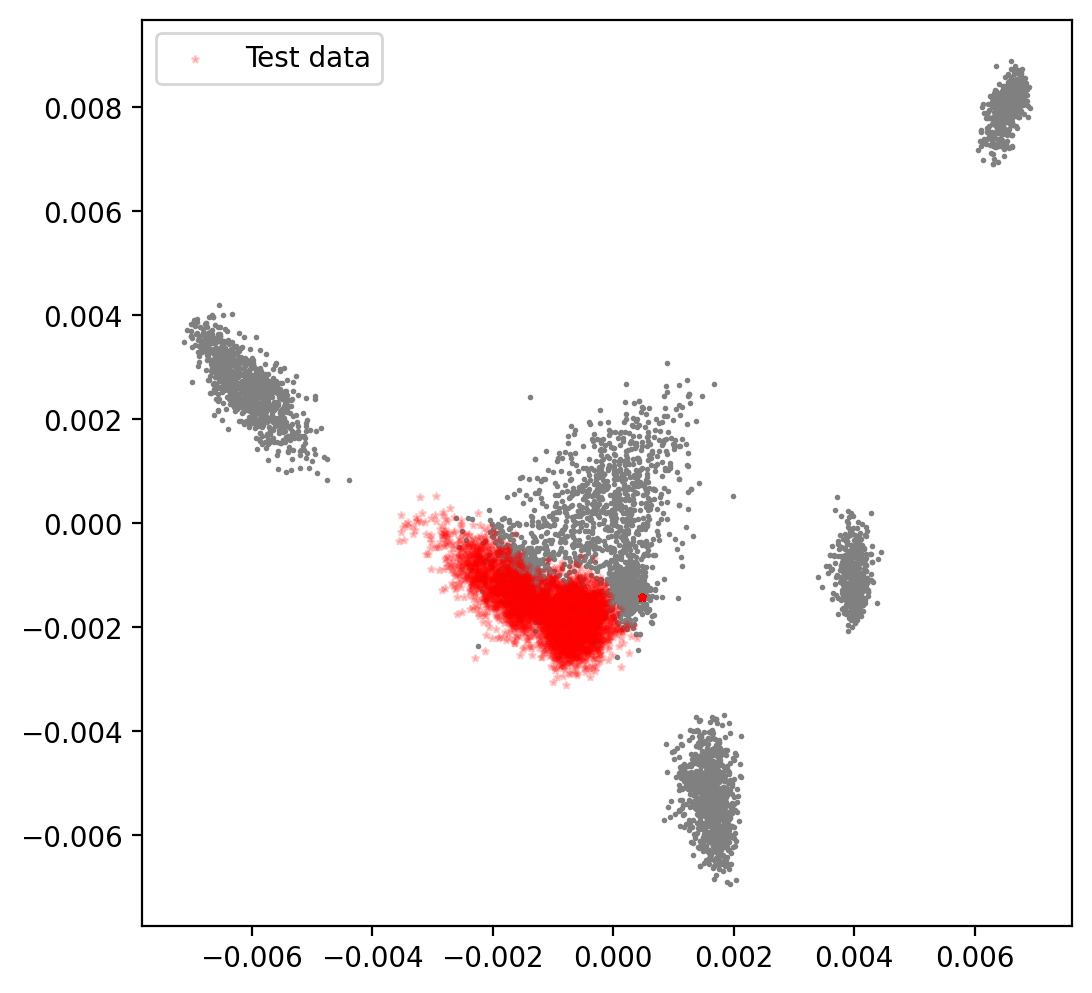

In [11]:
test_data = pd.read_csv(test_laaf_file, header=None).values
test_transformed = my_tslpp.transform(test_data)
f,ax = plt.subplots(figsize=(6,6),dpi=200)
ax.scatter(*projected_data.T, color = '0.5', s = 1)
ax.scatter(*test_transformed.T, color = 'red', s = 5, marker='*', label='Test data',alpha=0.2)
ax.legend()
plt.show()

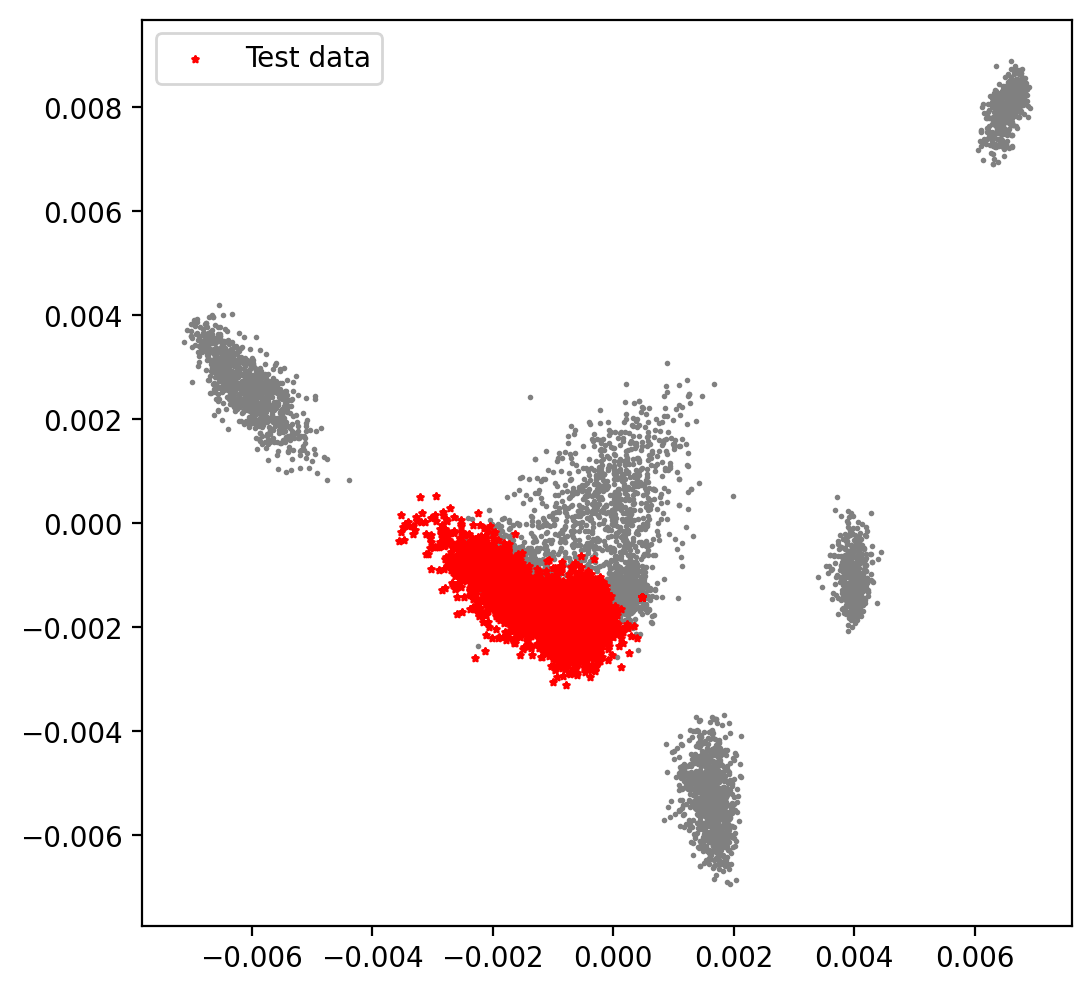

In [12]:
test_data = pd.read_csv(test_laaf_file, header=None).values
test_transformed = my_tslpp.transform(test_data)
f,ax = plt.subplots(figsize=(6,6),dpi=200)
ax.scatter(*projected_data.T, color = '0.5', s = 1)

ax.scatter(*test_transformed.T, color = 'red', s = 5, marker='*', label='Test data')
ax.legend()
plt.show()

In [13]:
test_transformed

array([[ 0.00047403, -0.00142879],
       [ 0.00047405, -0.00142878],
       [ 0.00047406, -0.00142878],
       ...,
       [-0.00142589, -0.00172042],
       [-0.00144247, -0.00172322],
       [-0.00117085, -0.00178929]])